In [1]:
import librosa
import h5py
import numpy as np
from os import listdir
import sklearn
from sklearn.preprocessing import normalize

import keras
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

Using TensorFlow backend.


In [2]:
data_list = ['bed', 'bird', 'cat', 'dog', 'down',
             'eight', 'five', 'four', 'go', 'happy']

In [5]:
for file_list in range(len(data_list)):
    data_name = data_list[file_list]
    file_list = librosa.util.find_files(("data/" + data_name), ext = 'wav')
    file_list = list(set(file_list)) # 겹치는 파일을 집합으로 만들어서 중복없애기
    #print(i)
    for file in file_list:
        y, sr = librosa.load(file)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        name = file[-22:-4]
        # normalization
        mfcc = normalize(mfcc)
        
        # write
        if(mfcc.shape != (20,44)):
            h5f = h5py.File("no_feature/" + name + ".h5", 'w')
        else:
            # reshape
            mfcc = mfcc.reshape(1,20,44)
            h5f = h5py.File("feature/"+ data_name + name + ".h5", 'w')
            h5f.create_dataset('arr', data=mfcc)
            h5f.close()

In [6]:
label_list = [[1,0,0,0,0,0,0,0,0,0],
              [0,1,0,0,0,0,0,0,0,0],
              [0,0,1,0,0,0,0,0,0,0],
              [0,0,0,1,0,0,0,0,0,0],
              [0,0,0,0,1,0,0,0,0,0],
              [0,0,0,0,0,1,0,0,0,0],
              [0,0,0,0,0,0,1,0,0,0],
              [0,0,0,0,0,0,0,1,0,0],
              [0,0,0,0,0,0,0,0,1,0],
              [0,0,0,0,0,0,0,0,0,1]]
count = 0

arr_data = np.empty((0,20,44)) # 빈 배열 생성
y_data = np.empty((0,10)) # label 배열

for h5_list in range(len(data_list)):
    h5_name = data_list[h5_list]
    h5_list = librosa.util.find_files('feature/' + h5_name, ext = 'h5') # 읽기전용 리스트
    h5_list = list(set(h5_list)) # 겹치는 파일을 집합으로 만들어서 중복없애기
    
    for file in h5_list:
        name = file[-21:-3]
        h5f = h5py.File("feature/"+ h5_name + name + ".h5", 'r')
        b = h5f['arr'][:]
        k = np.array(b) # 배열에 h5파일 넣기
        arr_data = np.vstack((arr_data,k)) # h5배열 쌓기
        h5f.close()
        arr_label = np.array(label_list[count])
        y_data = np.vstack((y_data,arr_label))
    count += 1
    print(arr_data.shape)
    print(y_data.shape)
    #print(y_data)    

(1484, 20, 44)
(1484, 10)
(3005, 20, 44)
(3005, 10)
(4520, 20, 44)
(4520, 10)
(6067, 20, 44)
(6067, 10)
(8219, 20, 44)
(8219, 10)
(10330, 20, 44)
(10330, 10)
(12491, 20, 44)
(12491, 10)
(14649, 20, 44)
(14649, 10)
(16750, 20, 44)
(16750, 10)
(18299, 20, 44)
(18299, 10)


In [7]:
x = arr_data #  추출한 값을 합치기
y = y_data   #  라벨 합치기
print(x.shape) # 데이터중에 쓸 수 있는 값의 갯수
print(y.shape)

(18299, 20, 44)
(18299, 10)


In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape)
print(x_test.shape)

(14639, 20, 44)
(3660, 20, 44)


In [9]:
batch_size = 256
nb_classes = 10
nb_epoch = 20

# input input dimensions
in_rows, in_cols = 20, 44
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

In [10]:
x_train = x_train.reshape(x_train.shape[0], in_rows, in_cols, 1)
x_test = x_test.reshape(x_test.shape[0], in_rows, in_cols, 1)
input_shape = (in_rows, in_cols, 1)
print('x_train shape:', x_train.shape)

x_train shape: (14639, 20, 44, 1)


In [11]:
model = None
model = Sequential()

model.add(Conv2D(nb_filters, kernel_size, padding='valid', input_shape=input_shape))
BatchNormalization(axis=-1)
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, kernel_size))
BatchNormalization(axis=-1)
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(nb_filters, kernel_size))
BatchNormalization(axis=-1)
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, kernel_size))
BatchNormalization(axis=-1)
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(64))
BatchNormalization()
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='Adadelta',
              metrics=['accuracy'])

hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epoch,
          verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 14639 samples, validate on 3660 samples
Epoch 1/20
14639/14639 [==============================] - 61s - loss: 2.2878 - acc: 0.1230 - val_loss: 2.2674 - val_acc: 0.1617
Epoch 2/20
14639/14639 [==============================] - 59s - loss: 2.2265 - acc: 0.1811 - val_loss: 2.1373 - val_acc: 0.2235
Epoch 3/20
14639/14639 [==============================] - 52s - loss: 2.0392 - acc: 0.2788 - val_loss: 1.9176 - val_acc: 0.3057
Epoch 4/20
14639/14639 [==============================] - 54s - loss: 1.8164 - acc: 0.3700 - val_loss: 1.4896 - val_acc: 0.5128
Epoch 5/20
14639/14639 [==============================] - 53s - loss: 1.5631 - acc: 0.4683 - val_loss: 1.3137 - val_acc: 0.5596
Epoch 6/20
14639/14639 [==============================] - 57s - loss: 1.3691 - acc: 0.5321 - val_loss: 1.2521 - val_acc: 0.5702
Epoch 7/20
14639/14639 [==============================] - 54s - loss: 1.1759 - acc: 0.6034 - val_loss: 0.9735 - val_acc: 0.6915
Epoch 8/20
14639/14639 [==============================]

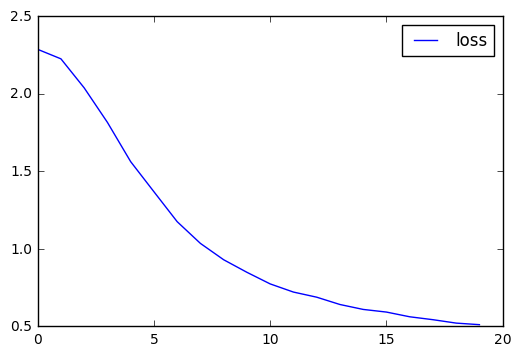

In [12]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'], label="loss")
plt.legend()
plt.show()

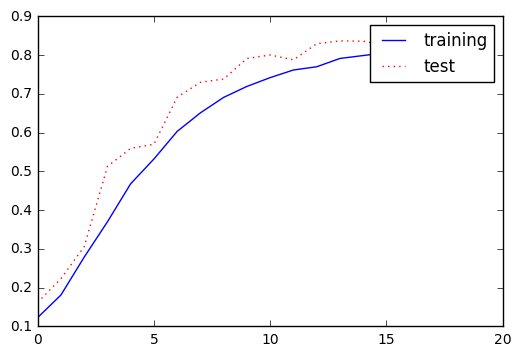

In [13]:
plt.plot(hist.history['acc'], 'b', label="training")
plt.plot(hist.history['val_acc'], 'r:', label="test")
plt.legend()
plt.show()